In [1]:
!unzip data_news.zip

Archive:  data_news.zip
  inflating: data_news.csv           


In [61]:
#Importing all the libraries
import pandas as pd
import numpy as np
import string, os 

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, TimeDistributed, Dropout, LSTMCell, RNN
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, CuDNNLSTM
from tensorflow.keras.layers import Bidirectional, Concatenate, Layer
from tensorflow.keras import backend as K

import re
import numpy as np
import os

from attention import AttentionLayer

Using TensorFlow backend.


In [4]:
#Read the dataset
df = pd.read_csv("data_news.csv").sample(1000)
df.head()

,publish_date,headline_category,headline_text
782273,20090821,city.rajkot,Dabba trading racket busted; 2 nabbed
959022,20100927,city.mumbai,No HC relief for youth who raped 12-year-old girl
852587,20100116,business.india-business,3G may be non-starter in 2010
1835248,20140702,city.chandigarh,Companies agree to lower cement prices
826414,20091115,home.sunday-times.deep-focus,Sachin's focus made him more successful: Imran...


In [6]:
#Pre-process the dataset
def process(sent):
    string=re.sub(r'\([^)]*\)', ' ', sent)
    string=re.sub(r'\[[^)]*\]', ' ', string)
    string=string.replace("\n"," ")
    string=string.strip()
    string=re.sub('[^.a-zA-Z]',' ',string)
    string=string.lower()
    return string

df['processed_news']=df['headline_text'].apply(process)
df.head()

,publish_date,headline_category,headline_text,processed_news
782273,20090821,city.rajkot,Dabba trading racket busted; 2 nabbed,dabba trading racket busted nabbed
959022,20100927,city.mumbai,No HC relief for youth who raped 12-year-old girl,no hc relief for youth who raped year old girl
852587,20100116,business.india-business,3G may be non-starter in 2010,g may be non starter in
1835248,20140702,city.chandigarh,Companies agree to lower cement prices,companies agree to lower cement prices
826414,20091115,home.sunday-times.deep-focus,Sachin's focus made him more successful: Imran...,sachin s focus made him more successful imran...


In [8]:
#Consider only those sentences having word lenght > 2
string_list=[]
for i in df['processed_news'].values:
    length=len(i.split())
    if(length>12):
        string_list.append(i)

In [9]:
len(string_list)

32

In [1]:
"""
import pandas as pd
import re
import numpy as np
import tensorflow as tf
file = open("demo_text.txt","r") 
string=file.read()

string=re.sub(r'\([^)]*\)', '', string)
string=re.sub(r'\[[^)]*\]', '', string)
string=string.replace("\n","")
string=string.strip()
string=re.sub('[^.a-zA-Z]',' ',string)
string=string.lower()
string_list=string.split(".")
"""

In [10]:
#Prepare a corpus of all the words present
corpus=" ".join(string_list)
corpus=corpus+" "+"<start>"+" "+"<end>"
corpus_words=corpus.split()
corpus_set=list(set(sorted(corpus_words)))
len(corpus_set)

348

In [11]:
#Mapping between word and index, reverse mapping of word an index
word_to_index= {word: index for (index, word) in enumerate(corpus_set)}
index_to_word = {index: word for (word, index) in word_to_index.items()}

In [12]:
#Create the dataset
def generate_dataset():
    X_data=[]
    Y_data=[]

    for sent in string_list:
        for i in range(len(sent.split())):
            X=['<start> ']+ sent.split()[:i+1] + [' <end>']
            X=" ".join(X)
            Y=['<start> ']+ sent.split()[i+1:] + [' <end>']
            Y=" ".join(Y)
            X_data.append(X)
            Y_data.append(Y)

    data=pd.DataFrame()
    data["input"]=X_data
    data["output"]=Y_data
    
    return data

#Encoding the string to number sequences(word level encoding)
def encode_string(string):
    encoded_list=[]
    raw_words=string.split()
    for word in raw_words:
        idx=word_to_index[word]
        encoded_list.append(idx)
        
    return encoded_list

#Post padding of input sentences based on max_len paramter
def pad_sequences(input_list, max_len):
    pads=max_len-len(input_list)
    zero_seq=[0]*pads
    input_list.extend(zero_seq)
    return input_list    

In [13]:
data=generate_dataset()
data.head()

,input,output
0,<start> hyderabad <end>,<start> drugs case suresh babu s courier attr...
1,<start> hyderabad drugs <end>,<start> case suresh babu s courier attracts e...
2,<start> hyderabad drugs case <end>,<start> suresh babu s courier attracts excise...
3,<start> hyderabad drugs case suresh <end>,<start> babu s courier attracts excise sleuth...
4,<start> hyderabad drugs case suresh babu <end>,<start> s courier attracts excise sleuths to ...


In [14]:
#Encode the strings to output string
data['encoded_input']=data['input'].apply(encode_string)
data['encoded_output']=data['output'].apply(encode_string)

In [15]:
data.head()

,input,output,encoded_input,encoded_output
0,<start> hyderabad <end>,<start> drugs case suresh babu s courier attr...,"[303, 105, 13]","[303, 243, 186, 132, 63, 179, 308, 53, 331, 19..."
1,<start> hyderabad drugs <end>,<start> case suresh babu s courier attracts e...,"[303, 105, 243, 13]","[303, 186, 132, 63, 179, 308, 53, 331, 196, 39..."
2,<start> hyderabad drugs case <end>,<start> suresh babu s courier attracts excise...,"[303, 105, 243, 186, 13]","[303, 132, 63, 179, 308, 53, 331, 196, 39, 106..."
3,<start> hyderabad drugs case suresh <end>,<start> babu s courier attracts excise sleuth...,"[303, 105, 243, 186, 132, 13]","[303, 63, 179, 308, 53, 331, 196, 39, 106, 274..."
4,<start> hyderabad drugs case suresh babu <end>,<start> s courier attracts excise sleuths to ...,"[303, 105, 243, 186, 132, 63, 13]","[303, 179, 308, 53, 331, 196, 39, 106, 274, 13]"


In [19]:
#Get max length of input and output strings
max_length_input=max([len(i) for i in data.encoded_input.values])
max_length_output=max([len(i) for i in data.encoded_output.values])

In [20]:
#Creating a list of list of encoded_sequences => [[a,b,c],[d,e,f,g]]
input_data=[i for i in data.encoded_input.values]
output_data=[i for i in data.encoded_output.values]

In [21]:
#Pad the sequences by appending zeros at the end
data['padded_input']=data['encoded_input'].apply(lambda x: pad_sequences(x, max_length_input))
data['padded_output']=data['encoded_output'].apply(lambda x: pad_sequences(x, max_length_output))

In [43]:
#Convert the padded list of list to a numpy array
import numpy as np
padded_input=np.array([i for i in data.padded_input.values])
padded_output=np.array([i for i in data.padded_output.values]) #padded_output.shape = (x,y)

In [52]:
#Remove start and end ineteger encodings
target_data = [[padded_output[n][i+1] for i in range(len(padded_output[n])-1)] for n in range(len(padded_output))]

#pad the sequence after removing the start/emd integers
target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=max_length_output, padding="post")

#target_data.shape =(x,y,1)
target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))

In [58]:
BUFFER_SIZE = len(input_data)
BATCH_SIZE = 128
embedding_dim = 300
vocab_size = len(word_to_index.keys())

In [54]:
print(vocab_in_size)

348


In [63]:
#Encoder Layers
encoder_inputs = Input(shape=(max_length_input,))
encoder_emb = Embedding(input_dim=vocab_size, output_dim=embedding_dim)
encoder_lstm = Bidirectional(CuDNNLSTM(units=128, 
                                       return_sequences=True, 
                                       return_state=True))
encoder_outputs, fstate_h, fstate_c, bstate_h, bstate_c = encoder_lstm(encoder_emb(encoder_inputs))
state_h = Concatenate()([fstate_h,bstate_h])
state_c = Concatenate()([bstate_h,bstate_c])
encoder_states = [state_h, state_c]


#Decoder layers
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim)
decoder_lstm = CuDNNLSTM(units=256, 
                         return_sequences=True, 
                         return_state=True)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(decoder_emb(decoder_inputs), 
                                                                      initial_state=encoder_states)


# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Adding two dense layers to the model to improve inference capabilities.
decoder_d1 = Dense(128, activation="relu")
decoder_d2 = Dense(vocab_out_size, activation="softmax")
decoder_out = decoder_d2(Dropout(rate=0.3)(decoder_d1(Dropout(rate=0.3)(decoder_outputs))))

#Creating a training model which combined the encoder decoder.
model = Model(inputs = [encoder_inputs, decoder_inputs], outputs= decoder_out)

#Compile the model
model.compile(optimizer=optimizers.Adam(lr=0.0001), 
              loss="sparse_categorical_crossentropy", 
              metrics=['sparse_categorical_accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 23)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 23, 300)      104400      input_8[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) [(None, 23, 256), (N 440320      embedding_6[0][0]                
__________________________________________________________________________________________________
embedding_

In [25]:
#20% validation split, TODO: Split the original data into train and validation
epochs = 10
history = model.fit([input_data, padded_output], target_data,
                 batch_size= BATCH_SIZE,
                 epochs=epochs,
                 validation_split=0.2)

W0904 03:51:19.018886 140120199055104 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1082193 samples, validate on 270549 samples
Epoch 1/10
1082193/1082193 [==============================] - 1299s 1ms/sample - loss: 1.3566 - sparse_categorical_accuracy: 0.8200 - val_loss: 1.4505 - val_sparse_categorical_accuracy: 0.8177
Epoch 2/10
1082193/1082193 [==============================] - 1293s 1ms/sample - loss: 0.9995 - sparse_categorical_accuracy: 0.8438 - val_loss: 1.5255 - val_sparse_categorical_accuracy: 0.8176
Epoch 3/10
1082193/1082193 [==============================] - 1293s 1ms/sample - loss: 0.8573 - sparse_categorical_accuracy: 0.8576 - val_loss: 1.6032 - val_sparse_categorical_accuracy: 0.8166
Epoch 4/10
1082193/1082193 [==============================] - 1292s 1ms/sample - loss: 0.7766 - sparse_categorical_accuracy: 0.8669 - val_loss: 1.6541 - val_sparse_categorical_accuracy: 0.8153
Epoch 5/10
1082193/1082193 [==============================] - 1293s 1ms/sample - loss: 0.7231 - sparse_categorical_accuracy: 0.8737 - val_loss: 1.7054 - val_sparse_categorical

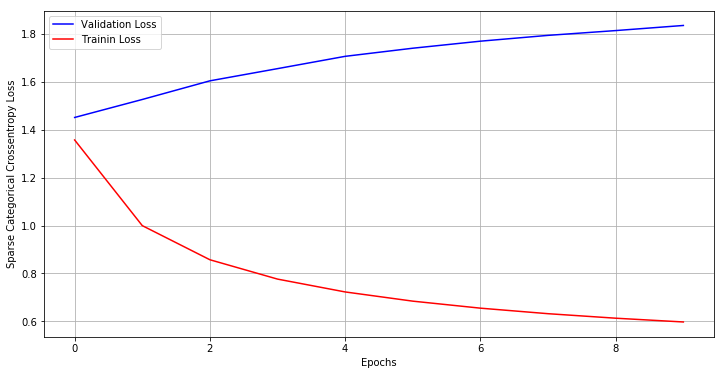

In [28]:
import matplotlib.pyplot as plt
def plt_epoch_error(x, val_error, train_error, colors=['b']):
    """
    This function is used to plot the loss vs epoch for the
    trained models using the History callback.
    """
    plt.figure(figsize=(12,6))
    plt.grid()
    plt.plot(x, val_error, 'b', label="Validation Loss")
    plt.plot(x, train_error, 'r', label="Trainin Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Sparse Categorical Crossentropy Loss")
    plt.legend()
    
#List of epoch numbers
x = list(range(0,len(history.history['val_loss'])))

#Plot train vs test loss
val_error = history.history['val_loss'] 
train_error = history.history['loss'] 
plt_epoch_error(x, val_error, train_error)

In [64]:
# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

#Generate a new set of tensors for inference decoder. 
inference_decoder_inputs = Input(shape=(None,), name="inference_decoder_inputs")

# We'll need to force feed the two state variables into the decoder each step.
state_input_h = Input(shape=(units*2,), name="state_input_h")
state_input_c = Input(shape=(units*2,), name="state_input_c")
decoder_res, decoder_h, decoder_c = decoder_lstm(decoder_emb(inference_decoder_inputs), 
                                                 initial_state=[state_input_h, state_input_c])
inference_decoder_out = decoder_d2(decoder_d1(decoder_res))
inference_model = Model(inputs=[inference_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inference_decoder_out, decoder_h, decoder_c])

In [30]:
# Converts the given sentence (just a string) into a vectortor of word IDs
# Output is 1-D: [timesteps/words]

def sentence_to_vector(sentence):
    vector = np.zeros(max_length_input)
    word_list = [word_to_index[word] for word in sentence.split(' ')]
    for idx,word in enumerate(word_list):
        vector[idx] = word
    return vector

# Given an input string, an encoder model (infenc_model) and a decoder model (infmodel),
def translate(input_sentence, infenc_model, infmodel):
    sv = sentence_to_vector(input_sentence)
    sv = sv.reshape(1,len(sv))
    [emb_out, sh, sc] = infenc_model.predict(x=sv)
    
    i = 0
    start_vector = word_to_index["<start>"]
    stop_vector = word_to_index["<end>"]
    
    cur_vector = np.zeros((1,1))
    cur_vector[0,0] = start_vector
    cur_word = "<start>"
    output_sentence = ""

    while cur_word != "<end>" and i < (max_length_output-1):
        i += 1
        if cur_word != "<start>":
            output_sentence = output_sentence + " " + cur_word
        x_in = [cur_vector, sh, sc]
        [nvector, sh, sc] = infmodel.predict(x=x_in)
        cur_vector[0,0] = np.argmax(nvector[0,0])
        cur_word = index_to_word[np.argmax(nvector[0,0])]
    return output_sentence

In [101]:
def generate_output(sent):
    input_sent=sent.lower()
    output_sent=translate(input_sent, encoder_model, inf_model)
    final_sent=sent+""+output_sent+"\n"
    print(final_sent)


test = ['machine has',
       'we are here',
       'this is not',
       'can we cover the news',
       'this is a very bad state',
       'the death',
       'the arrest',
       'america is',
       'the bjp government',
       'this is a first time',
       'he has been doing',
       'the newspapers are',
       'this is exactly',
       'fissures in hurriyat',
       'we are actively',
       'there is a small role',
       'the film is too bad',
        'can we have a',
       'is this',
        'the film is to be',
       'akshay kumar is going']


for sent in test:
    generate_output(sent)

machine has to be a new year in a fix on the first time in months

we are here in the fantastic a reminder that people will be on it says uddhav

this is not a meaty role in a film with a newcomer says aarambh actress karthika nair

can we cover the news to be a part of the world s biggest world cup

this is a very bad state to be a neech person who was morally corrupt

the death of the hobbit will have a lot of intensity that we prove scripts

the arrest of the hobbit will have a lot of grey s real life charles sobhraj

america is to be a new motto for a way for bjp s next

the bjp government to be a new lease of life in the state of gandhigram

this is a first time to be a shade of grey in comics with adjustments

he has been doing in the newspapers for a good time in the race for bilingual film run

the newspapers are targaryen and samrat and a showstopper at the duchess utsav and bridal marriott hotel in chennai

this is exactly the nuns love my way to portray them as luck says lou